In [2]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
#import squarify
from datetime import datetime
from dateutil import parser
from datetime import datetime
import timeit
import seaborn as sns

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mathchi/online-retail-ii-data-set-from-ml-repository")

print("Path to dataset files:", path)

100%|██████████| 57.5M/57.5M [00:00<00:00, 78.3MB/s]

Extracting files...


Path to dataset files: /Users/mac/.cache/kagglehub/datasets/mathchi/online-retail-ii-data-set-from-ml-repository/versions/3


In [12]:
df=pd.read_csv('/Users/mac/.cache/kagglehub/datasets/mathchi/online-retail-ii-data-set-from-ml-repository/versions/3/Year 2010-2011.csv',encoding="ISO-8859-1")

In [13]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [15]:
df['Price']=pd.to_numeric(df['Price'])

In [16]:
df.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

In [20]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [21]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [23]:
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)
print(snapshot_date)

2011-12-10 12:50:00


In [24]:
data_process = df.groupby(['Customer ID']).agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'Customer ID': 'count',
        'Price': 'sum'})

In [25]:
data_process


,InvoiceDate,Customer ID,Price
Customer ID,,,
12346.0,326,2,2.08
12347.0,2,182,481.21
12348.0,75,31,178.71
12349.0,19,73,605.10
12350.0,310,17,65.30
...,...,...,...
18280.0,278,10,47.65
18281.0,181,7,39.36
18282.0,8,13,62.68


In [26]:
data_process.rename(columns={'InvoiceDate': 'Recency',
                         'Customer ID': 'Frequency',
                         'Price': 'MonetaryValue'}, inplace=True)

/var/folders/vw/3sdh37pd2cg30sctbp_d410m0000gn/T/ipykernel_20646/1874037494.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(data_process['Recency'])
/var/folders/vw/3sdh37pd2cg30sctbp_d410m0000gn/T/ipykernel_20646/1874037494.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.su

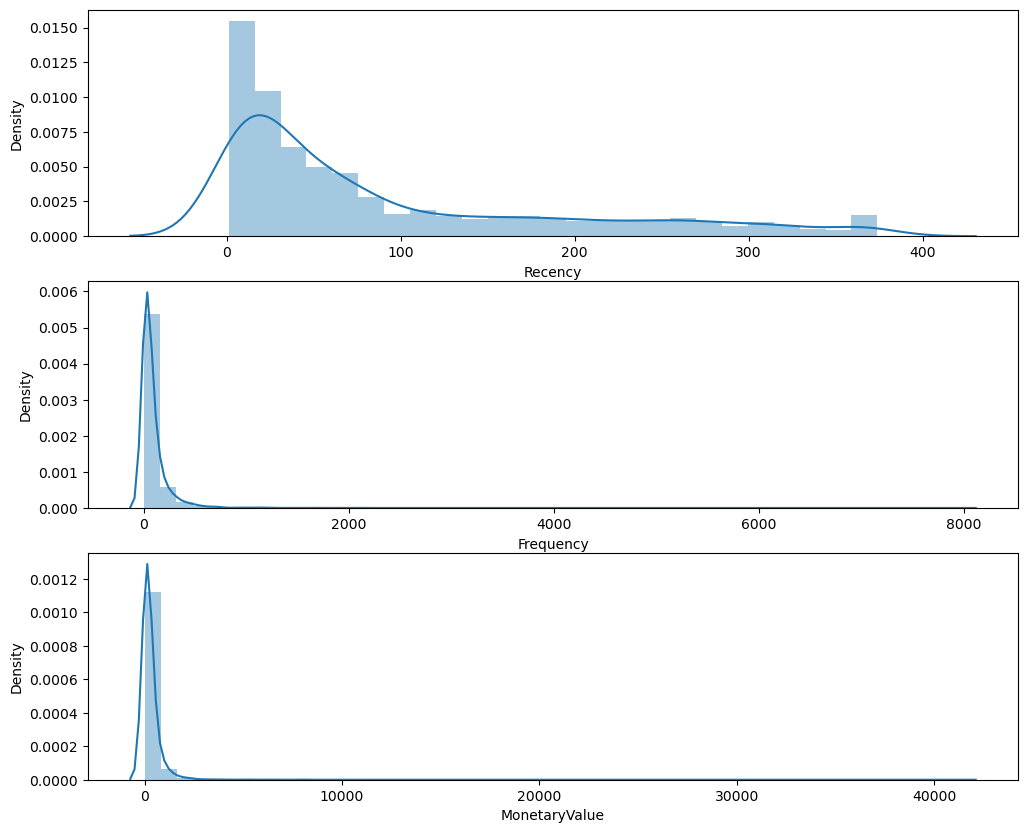

In [27]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(data_process['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(data_process['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(data_process['MonetaryValue'])
# Show the plot
plt.show()

In [28]:
def pct_rank_qcut(series, n):
    edges = pd.Series([float(i) / n for i in range(n + 1)])
    f = lambda x: (edges >= x).argmax()
    return series.rank(pct=1).apply(f)

q = pct_rank_qcut(data_process.Frequency, 10)

In [36]:
# Create labels for Recency and Frequency
r_labels = [5, 4, 3, 2, 1]  # Explicitly define the labels
f_labels = [1, 2, 3]  # Ensure labels match the bin count

# Assign these labels to percentile groups
r_groups = pd.qcut(data_process['Recency'], q=5, labels=r_labels, duplicates='drop')
f_groups = pd.qcut(data_process['Frequency'], q=3, labels=f_labels, duplicates='drop')

# Create new columns R and F
data_process = data_process.assign(R=r_groups.values, F=f_groups.values)
data_process.head()


,Recency,Frequency,MonetaryValue,R,F
Customer ID,,,,,
12346.0,326,2,2.08,1,1
12347.0,2,182,481.21,5,3
12348.0,75,31,178.71,2,2
12349.0,19,73,605.10,4,2
12350.0,310,17,65.30,1,1


In [37]:
# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(data_process['MonetaryValue'], q=4, labels=m_labels)
# Create new column M
data_process = data_process.assign(M = m_groups.values)

In [38]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
data_process['RFM_Segment_Concat'] = data_process.apply(join_rfm, axis=1)
rfm = data_process
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat
Customer ID,,,,,,,
12346.0,326,2,2.08,1,1,1,1.01.01.0
12347.0,2,182,481.21,5,3,4,5.03.04.0
12348.0,75,31,178.71,2,2,3,2.02.03.0
12349.0,19,73,605.10,4,2,4,4.02.04.0
12350.0,310,17,65.30,1,1,2,1.01.02.0


In [39]:
# Count num of unique segments
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print(rfm_count_unique.sum())

52


In [40]:
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

Customer ID
12346.0     3
12347.0    12
12348.0     7
12349.0    10
12350.0     4
Name: RFM_Score, dtype: int64


In [41]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Platinium'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'GOLD'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Silver'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'New'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
Customer ID,,,,,,,,,
12346.0,326,2,2.08,1,1,1,1.01.01.0,3,Require Activation
12347.0,2,182,481.21,5,3,4,5.03.04.0,12,Platinium
12348.0,75,31,178.71,2,2,3,2.02.03.0,7,Silver
12349.0,19,73,605.10,4,2,4,4.02.04.0,10,Platinium
12350.0,310,17,65.30,1,1,2,1.01.02.0,4,New


In [42]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   Recency Frequency MonetaryValue      
                      mean      mean          mean count
RFM_Level                                               
GOLD                  61.3      58.3         191.3   426
New                  181.9      13.2          46.2   426
Platinium             23.5     194.9         653.6  1699
Potential            111.4      29.0         177.3   501
Promising            140.3      20.3          63.3   432
Require Activation   275.4       8.4          24.2   390
Silver                70.3      37.6         141.7   498


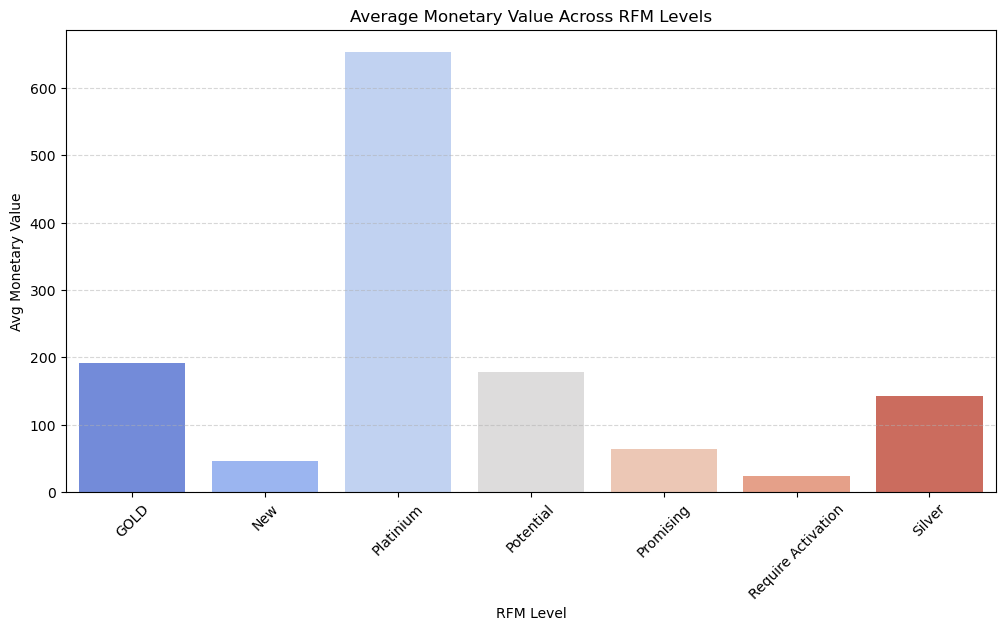

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reset index for easy plotting
rfm_level_agg.columns = ['Recency_mean', 'Frequency_mean', 'Monetary_mean', 'Count']
rfm_level_agg = rfm_level_agg.reset_index()

# Plot grouped bar chart
plt.figure(figsize=(12,6))
sns.barplot(x='RFM_Level', y='Monetary_mean', data=rfm_level_agg, palette='coolwarm')

plt.title('Average Monetary Value Across RFM Levels')
plt.xlabel('RFM Level')
plt.ylabel('Avg Monetary Value')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


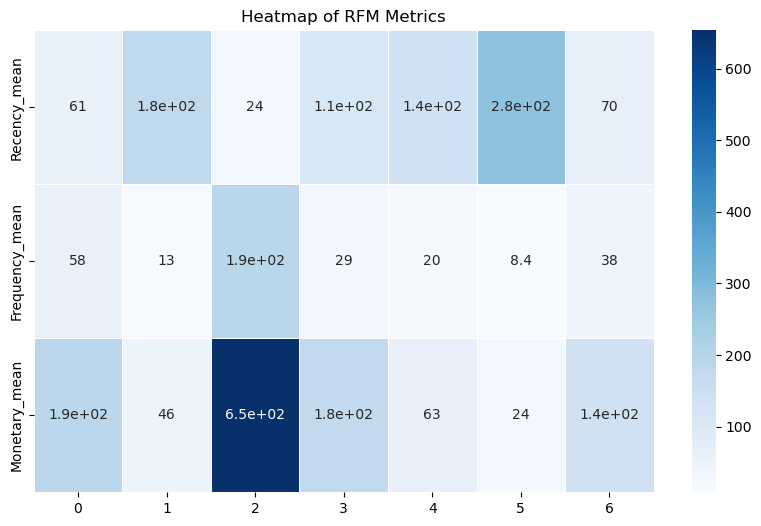

In [44]:
plt.figure(figsize=(10,6))
sns.heatmap(rfm_level_agg[['Recency_mean', 'Frequency_mean', 'Monetary_mean']].transpose(), annot=True, cmap="Blues", linewidths=0.5)
plt.title('Heatmap of RFM Metrics')
plt.show()


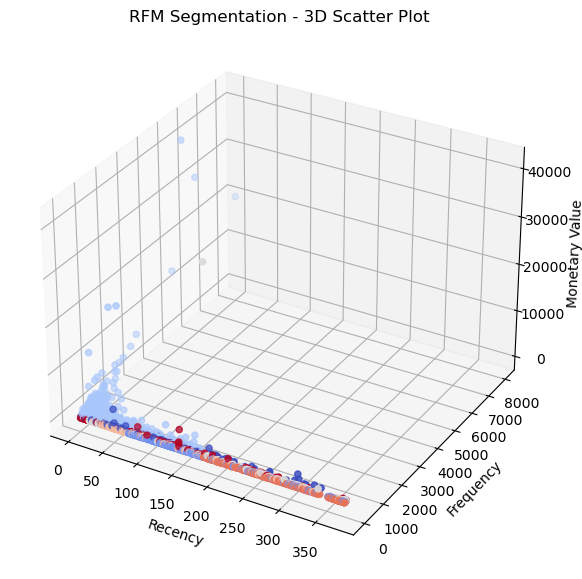

In [45]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Create 3D scatter plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['MonetaryValue'], c=rfm['RFM_Level'].astype('category').cat.codes, cmap='coolwarm')

# Label axes
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value')
ax.set_title('RFM Segmentation - 3D Scatter Plot')

plt.show()


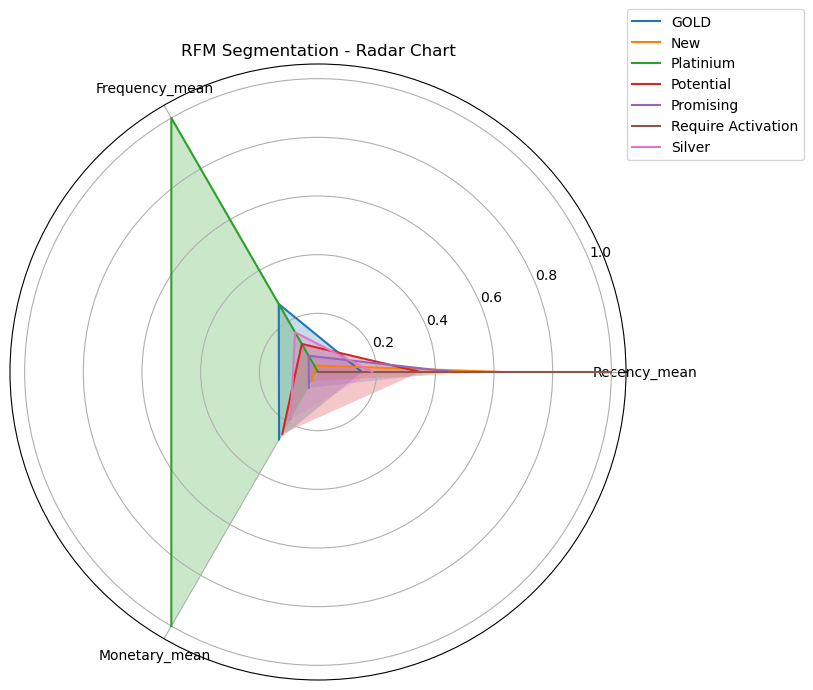

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Normalize data for radar chart
rfm_level_agg_norm = (rfm_level_agg[['Recency_mean', 'Frequency_mean', 'Monetary_mean']] - 
                      rfm_level_agg[['Recency_mean', 'Frequency_mean', 'Monetary_mean']].min()) / (
                      rfm_level_agg[['Recency_mean', 'Frequency_mean', 'Monetary_mean']].max() - 
                      rfm_level_agg[['Recency_mean', 'Frequency_mean', 'Monetary_mean']].min())

# Prepare data
categories = list(rfm_level_agg_norm.columns)
labels = list(rfm_level_agg['RFM_Level'])
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()

# Plot radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for i, label in enumerate(labels):
    values = rfm_level_agg_norm.iloc[i].values.flatten().tolist()
    ax.plot(angles, values, label=label)
    ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles)
ax.set_xticklabels(categories)
plt.title('RFM Segmentation - Radar Chart')
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show()
